# Verification experiments (contractive)
_Author: Bart van Erp_ 

_Date:   16-02-2022_

This notebook contains the verification experiments to the paper **Model-Based Source Separation Using Invertible Neural Networks**.

## Load packages

In [1]:
using Revise
using SourceSeparationINN
using LinearAlgebra, Random, Distributions
using HDF5, JLD2
using PyPlot

BLAS.set_num_threads(1)
Random.seed!(1234);

## Load data

In [2]:
# generate data if it does not exist yet
t = 0:0.01:10
if !isdir("data")

    # create folders
    mkdir("data")
    mkdir("data/signal")
    mkdir("data/noise")
    mkdir("data/mix")
    mkdir("data/mix_signal")
    mkdir("data/mix_noise")

    # generate data and save
    start_signal = 10*randn(1000)
    start_noise  = 10*randn(1000)
    start_mix    = 10*randn(2000)
    amps         = 5*rand(3000)
    for k = 1:1000
        h5write(string("data/signal/", k, ".h5"), "signal", amps[k]* 2 .* ((start_signal[k].+collect(t)).*12 .- floor.(1/2 .+ (start_signal[k].+collect(t)).*12)))
        h5write(string("data/noise/",  k, ".h5"), "signal", amps[k]* sign.(cos.(start_noise[k].+2*π*10*collect(t))))
        h5write(string("data/mix/",    k, ".h5"), "signal", amps[k+1000]*2 .* ((t.+start_mix[k]).*12 .-floor.(1/2 .+ (collect(t).+start_mix[k]).*12))  .+ amps[k+2000]*sign.(cos.(start_mix[k+1000].+2*π*10*collect(t))))
        h5write(string("data/mix_signal/", k, ".h5"), "signal", amps[k+1000]*2 .* ((t.+start_mix[k]).*12 .-floor.(1/2 .+ (collect(t).+start_mix[k]).*12))) 
        h5write(string("data/mix_noise/",  k, ".h5"), "signal", amps[k+2000]*sign.(cos.(start_mix[k+1000].+2*π*10*collect(t))))
    end

end

In [3]:
# load data
data_signal = Data("data/signal/" .* readdir("data/signal"), Float64)
data_noise  = Data("data/noise/"  .* readdir("data/noise"),  Float64)
data_mix    = Data("data/mix/"    .* readdir("data/mix"),    Float64)
data_mix_signal = Data("data/mix_signal/"    .* readdir("data/mix_signal"), Float64)
data_mix_noise  = Data("data/mix_noise/"    .* readdir("data/mix_noise"),  Float64);

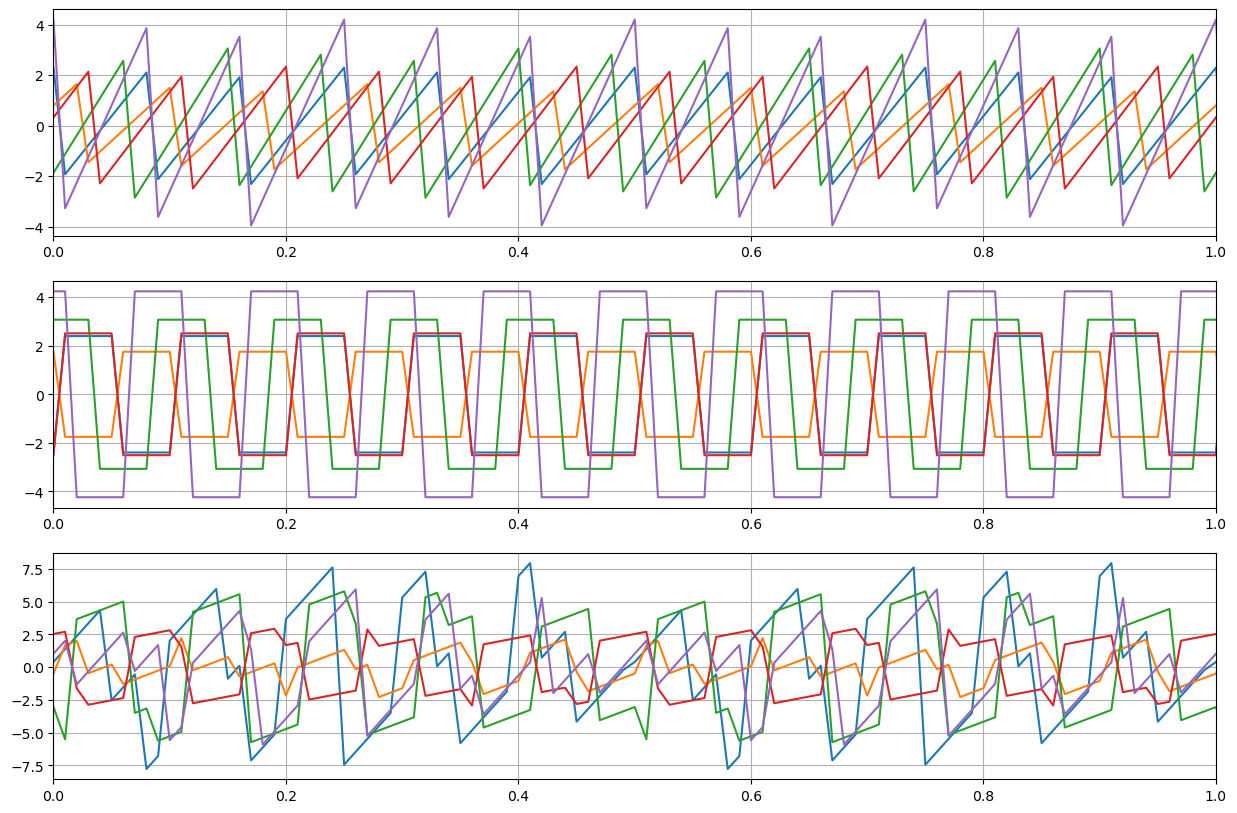

In [4]:
_, ax = plt.subplots(figsize=(15,10), nrows=3)
for k in 1:5
    ax[1].plot(t, data_signal[k])
    ax[2].plot(t, data_noise[k])
    ax[3].plot(t, data_mix[k])
end
ax[1].set_xlim(0,1), ax[1].grid()
ax[2].set_xlim(0,1), ax[2].grid()
ax[3].set_xlim(0,1), ax[3].grid();

## Train models

In [5]:
function create_contractive_model(dim; shift=1, batch_size::Int=128)

    return Model(
        dim,
        (
            ARLayer(
                dim,
                Model(  
                    dim-shift,
                    shift,
                    (   
                        DenseSNLayer(dim-shift, 16, 1.0; batch_size=batch_size, optimizer=Adam),
                        LeakyReluLayer(16; batch_size=batch_size),
                        DenseSNLayer(16, 16, 1.0; batch_size=batch_size, optimizer=Adam),
                        LeakyReluLayer(16; batch_size=batch_size),
                        DenseSNLayer(16, shift, 1.0; batch_size=batch_size, optimizer=Adam),
                    );
                    batch_size=batch_size
                );
                batch_size=batch_size
            ),
        );
        batch_size=batch_size
    )
        
end
batch_size = 16
dim_in = 16
loss_function_signal = MSE(batch_size=batch_size)
loss_function_noise  = MSE(batch_size=batch_size)
;

In [6]:
# load/train signal model
if isdir("logs/signal")

    # load model
    model_signal = load(string("logs/signal/", readdir("logs/signal")[1], "/model.jld2"))["model"]

else

    # create model
    model_signal = create_contractive_model(dim_in; batch_size=batch_size)

    # set learning rate
    # setlr!(model_signal, 1e-5)

    # create train suite
    train_suite_signal = TrainSuite(
        model_signal,           # model
        loss_function_signal,   # loss function
        data_signal,            # train data
        data_signal,            # test data
        5,                     # number of epochs
        "logs/signal/"          # path to log directory
    );

    # create folder
    mkdir("logs/signal")

    # train model
    run!(train_suite_signal)

end;

epoch 005: 100%|████████████████████████████████████████| Time: 0:00:09
  mse_train:  0.03922683246746584
  mse_test:   0.042822008316262865


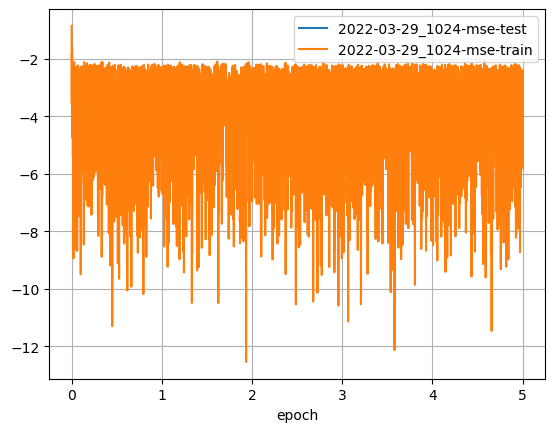

In [7]:
plot_logs(; path="logs/signal/", logscale=true);

In [8]:
# load/train noise model
if isdir("logs/noise")

    # load model
    model_noise = load(string("logs/noise/", readdir("logs/noise")[1], "/model.jld2"))["model"]

else

    # create model
    model_noise = create_contractive_model(dim_in; batch_size=batch_size)

    # set learning rate
    # setlr!(model_noise, 1e-5)

    # create train suite
    train_suite_noise = TrainSuite(
        model_noise,           # model
        loss_function_noise,   # loss function
        data_noise,            # train data
        data_noise,            # test data
        5,                    # number of epochs
        "logs/noise/"          # path to log directory
    );

    # create folder
    mkdir("logs/noise")

    # train model
    run!(train_suite_noise)

end;

epoch 005: 100%|████████████████████████████████████████| Time: 0:00:11
  mse_train:  3.530858067798914e-8
  mse_test:   1.2853210004092337e-6


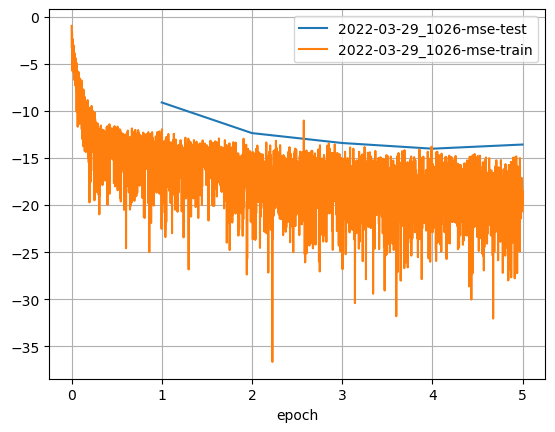

In [9]:
plot_logs(; path="logs/noise/", logscale=true);

## Kalman priors

In [10]:
H = zeros(2*dim_in)
H[1] = 1
H[1+dim_in] = 1

Q = zeros(2*dim_in, 2*dim_in)
R = 1e-10
Q[1,1] = exp(-2) * dim_in
Q[1+dim_in, 1+dim_in] = exp(-20) * dim_in

signal_mix = data_mix[1]

m_x_prior = randn(2*dim_in)
# m_x_prior = vcat(data_mix_signal[1][16:-1:1], data_mix_noise[1][16:-1:1])
V_x_prior = 1e2*diagm(ones(2*dim_in));
# V_x_prior = 1e-1*diagm(ones(2*dim_in));

## Extended Kalman filter/smoother

In [11]:
function EKF_old(signal_mix, model_signal, model_noise, m_x_prior, V_x_prior, H, R, Q; dim_in=16)

    # allocate output
    m_x_f = Vector{Vector{Float64}}(undef,length(signal_mix))
    V_x_f = Vector{Matrix{Float64}}(undef,length(signal_mix))

    # copy priors
    m_x = copy(m_x_prior)
    V_x = copy(V_x_prior)

    # kalman filtering
    for k in dim_in+1:length(signal_mix)
    
        # predict step
        m_x_new = vcat(forward(model_signal, m_x[1:dim_in]), forward(model_noise, m_x[dim_in+1:end]))
        F = vcat(hcat(jacobian(model_signal, m_x[1:dim_in]), zeros(dim_in, dim_in)), hcat(zeros(dim_in, dim_in), jacobian(model_noise, m_x[dim_in+1:end])))
        V_x_new = F*V_x*F' + Q
    
        # filtering messages
        y = signal_mix[k] - dot(H, m_x_new)
        S = dot(H, V_x_new, H) + R
        K = V_x_new * H * inv(S)
        m_x = m_x_new + K*y
        # V_x = V_x_new - K*S*K'
        V_x = (I - K*H')*V_x_new
    
        # save values
        m_x_f[k] = copy(m_x)
        V_x_f[k] = copy(V_x)
    
    end

    # copy output
    m_x_new = copy(m_x_f[end])
    V_x_new = copy(V_x_f[end])

    m_signal_filtering = [m_x_f[k][1]                       for k = dim_in+1:length(signal_mix)]
    V_signal_filtering = [V_x_f[k][1,1]                     for k = dim_in+1:length(signal_mix)]
    m_noise_filtering  = [m_x_f[k][1+dim_in]                for k = dim_in+1:length(signal_mix)]
    V_noise_filtering  = [V_x_f[k][1+dim_in,1+dim_in]       for k = dim_in+1:length(signal_mix)]

    # return output
    m_signal_filtering, V_signal_filtering, m_noise_filtering, V_noise_filtering
    
end

EKF_old (generic function with 1 method)

In [12]:
using LoopVectorization: @turbo

In [13]:
function EKF(signal_mix, model_signal, model_noise, m_x_prior, V_x_prior, R, Q; dim_in=16)

    # allocate output
    m_s_f = zeros(length(signal_mix))
    V_s_f = zeros(length(signal_mix))
    m_n_f = zeros(length(signal_mix))
    V_n_f = zeros(length(signal_mix))

    # initialize intermediate values
    K = zeros(2*dim_in)

    m_x_s_new = randn(dim_in)
    m_x_n_new = randn(dim_in)
    m_x_s = m_x_prior[1:dim_in]
    m_x_n = m_x_prior[1+dim_in:end]
    Jcs = CompanionMatrix(randn(dim_in))
    Jcn = CompanionMatrix(randn(dim_in))

    V_x_ss = V_x_prior[1:dim_in, 1:dim_in]
    V_x_sn = V_x_prior[1:dim_in, 1+dim_in:end]
    V_x_ns = V_x_prior[1+dim_in:end, 1:dim_in]
    V_x_nn = V_x_prior[1+dim_in:end, 1+dim_in:end]
    V_x_new_ss = randn(dim_in, dim_in)
    V_x_new_sn = randn(dim_in, dim_in)
    V_x_new_ns = randn(dim_in, dim_in)
    V_x_new_nn = randn(dim_in, dim_in)

    for k in 1:dim_in
        m_x_s[k] = m_x_prior[k]
        m_x_n[k] = m_x_prior[k+dim_in]
    end

    # kalman filtering
    @inbounds for k in dim_in+1:length(signal_mix)
    
        # update mean
        m_x_s_new .= forward(model_signal, m_x_s)
        m_x_n_new .= forward(model_noise, m_x_n)
        
        # update variance
        Js = jacobian(model_signal, m_x_s)
        Jn = jacobian(model_noise, m_x_n)
        @turbo for k in 1:dim_in
            Jcs.θ[k] = Js[1,k]
            Jcn.θ[k] = Jn[1,k]
        end
        SourceSeparationINN.tri_matmul!(V_x_new_ss, Jcs, V_x_ss, Jcs')
        V_x_new_ss[1,1] += Q[1,1]
        SourceSeparationINN.tri_matmul!(V_x_new_sn, Jcs, V_x_sn, Jcn')
        SourceSeparationINN.tri_matmul!(V_x_new_ns, Jcn, V_x_ns, Jcs')
        SourceSeparationINN.tri_matmul!(V_x_new_nn, Jcn, V_x_nn, Jcn')
        V_x_new_nn[1,1] += Q[1+dim_in, 1+dim_in]

    
        # filtering messages
        y = signal_mix[k] - m_x_s_new[1] - m_x_n_new[1] 
        S = V_x_new_ss[1,1] + V_x_new_sn[1,1] + V_x_new_ns[1,1] + V_x_new_nn[1,1] + R

        # calculate kalman gain
        @turbo for k = 1:dim_in
            K[k] = V_x_new_ss[k,1] + V_x_new_sn[k,1]
            K[k+dim_in] = V_x_new_ns[k,1] + V_x_new_nn[k,1]
        end
        K ./= S

        # update mean
        @turbo for k in 1:dim_in
            m_x_s[k] = m_x_s_new[k] + K[k]*y
            m_x_n[k] = m_x_n_new[k] + K[k+dim_in]*y
        end

        # update variance
        @turbo for m ∈ 1:dim_in, n ∈ 1:dim_in
            V_x_ss[m,n] = V_x_new_ss[m,n] - K[m] * V_x_new_ss[1,n] - K[m] * V_x_new_ns[1,n]
            V_x_sn[m,n] = V_x_new_sn[m,n] - K[m] * V_x_new_sn[1,n] - K[m] * V_x_new_nn[1,n]
            V_x_ns[m,n] = V_x_new_ns[m,n] - K[m+dim_in] * V_x_new_ss[1,n] - K[m+dim_in] * V_x_new_ns[1,n]
            V_x_nn[m,n] = V_x_new_nn[m,n] - K[m+dim_in] * V_x_new_sn[1,n] - K[m+dim_in] * V_x_new_nn[1,n]
        end

        # save values
        m_s_f[k] = m_x_s[1]
        V_s_f[k] = V_x_ss[1,1]
        m_n_f[k] = m_x_n[1]
        V_n_f[k] = V_x_nn[1, 1]

    end


    # return output
    return m_s_f, V_s_f, m_n_f, V_n_f
    
end

EKF (generic function with 1 method)

In [14]:
function EKF_deployed(signal_mix, model_signal, model_noise, m_x_prior, V_x_prior, R, Q; dim_in=16)

    # allocate output
    m_s_f = zeros(length(signal_mix))
    V_s_f = zeros(length(signal_mix))
    m_n_f = zeros(length(signal_mix))
    V_n_f = zeros(length(signal_mix))

    # initialize intermediate values
    K = zeros(2*dim_in)

    m_x_s = m_x_prior[1:dim_in]
    m_x_n = m_x_prior[1+dim_in:end]

    V_x_ss = V_x_prior[1:dim_in, 1:dim_in]
    V_x_sn = V_x_prior[1:dim_in, 1+dim_in:end]
    V_x_ns = V_x_prior[1+dim_in:end, 1:dim_in]
    V_x_nn = V_x_prior[1+dim_in:end, 1+dim_in:end]
    V_x_new_ss = randn(dim_in, dim_in)
    V_x_new_sn = randn(dim_in, dim_in)
    V_x_new_ns = randn(dim_in, dim_in)
    V_x_new_nn = randn(dim_in, dim_in)

    # kalman filtering
    @inbounds for k in dim_in+1:length(signal_mix)
    
        # run models forward
        m_x_s_new, Jcs = forward_jacobian!(model_signal, m_x_s)
        m_x_n_new, Jcn = forward_jacobian!(model_noise, m_x_n)

        SourceSeparationINN.tri_matmul!(V_x_new_ss, Jcs, V_x_ss, Jcs')
        V_x_new_ss[1,1] += Q[1,1]
        SourceSeparationINN.tri_matmul!(V_x_new_sn, Jcs, V_x_sn, Jcn')
        SourceSeparationINN.tri_matmul!(V_x_new_ns, Jcn, V_x_ns, Jcs')
        SourceSeparationINN.tri_matmul!(V_x_new_nn, Jcn, V_x_nn, Jcn')
        V_x_new_nn[1,1] += Q[1+dim_in, 1+dim_in]

    
        # filtering messages
        y = signal_mix[k] - m_x_s_new[1] - m_x_n_new[1] 
        S = V_x_new_ss[1,1] + V_x_new_sn[1,1] + V_x_new_ns[1,1] + V_x_new_nn[1,1] + R

        # calculate kalman gain
        @turbo for k = 1:dim_in
            K[k] = V_x_new_ss[k,1] + V_x_new_sn[k,1]
            K[k+dim_in] = V_x_new_ns[k,1] + V_x_new_nn[k,1]
        end
        K ./= S

        # update mean
        @turbo for k in 1:dim_in
            m_x_s[k] = m_x_s_new[k] + K[k]*y
            m_x_n[k] = m_x_n_new[k] + K[k+dim_in]*y
        end

        # update variance
        @turbo for m ∈ 1:dim_in, n ∈ 1:dim_in
            V_x_ss[m,n] = V_x_new_ss[m,n] - K[m] * V_x_new_ss[1,n] - K[m] * V_x_new_ns[1,n]
            V_x_sn[m,n] = V_x_new_sn[m,n] - K[m] * V_x_new_sn[1,n] - K[m] * V_x_new_nn[1,n]
            V_x_ns[m,n] = V_x_new_ns[m,n] - K[m+dim_in] * V_x_new_ss[1,n] - K[m+dim_in] * V_x_new_ns[1,n]
            V_x_nn[m,n] = V_x_new_nn[m,n] - K[m+dim_in] * V_x_new_sn[1,n] - K[m+dim_in] * V_x_new_nn[1,n]
        end

        # save values
        m_s_f[k] = m_x_s[1]
        V_s_f[k] = V_x_ss[1,1]
        m_n_f[k] = m_x_n[1]
        V_n_f[k] = V_x_nn[1, 1]

    end


    # return output
    return m_s_f, V_s_f, m_n_f, V_n_f
    
end

EKF_deployed (generic function with 1 method)

In [15]:
using BenchmarkTools

In [16]:
deployed_model_signal = deploy(model_signal);
deployed_model_noise = deploy(model_noise);

In [17]:
@benchmark EKF_deployed($signal_mix, $deployed_model_signal, $deployed_model_noise, $m_x_prior, $V_x_prior, $R, $Q)

BenchmarkTools.Trial: 2171 samples with 1 evaluation.
 Range (min … max):  2.032 ms …   7.186 ms  ┊ GC (min … max): 0.00% … 67.61%
 Time  (median):     2.283 ms               ┊ GC (median):    0.00%
 Time  (mean ± σ):   2.297 ms ± 156.046 μs  ┊ GC (mean ± σ):  0.19% ±  2.05%

                               ▅▆▇██▅▆▃▂▁▁                     
  ▂▁▂▁▂▁▂▂▂▂▂▂▁▂▂▂▂▂▁▂▂▂▁▂▂▃▄▅▇███████████▇█▆▆▅▅▅▄▃▃▃▃▂▃▃▂▂▂▂ ▄
  2.03 ms         Histogram: frequency by time        2.46 ms <

 Memory estimate: 80.48 KiB, allocs estimate: 1985.

In [18]:
@benchmark EKF($signal_mix, $model_signal, $model_noise, $m_x_prior, $V_x_prior, $R, $Q)

┌ Warning: #= In[13]:43 =#:
│ `LoopVectorization.check_args` on your inputs failed; running fallback `@inbounds @fastmath` loop instead.
│ Use `warn_check_args=false`, e.g. `@turbo warn_check_args=false ...`, to disable this warning.
└ @ Main C:\Users\s151781\.julia\packages\LoopVectorization\wLMFa\src\condense_loopset.jl:825


BenchmarkTools.Trial: 360 samples with 1 evaluation.
 Range (min … max):   5.872 ms … 27.346 ms  ┊ GC (min … max):  0.00% … 35.37%
 Time  (median):     15.575 ms              ┊ GC (median):     0.00%
 Time  (mean ± σ):   13.906 ms ±  6.174 ms  ┊ GC (mean ± σ):  16.03% ± 18.88%

  █▃▁▁                            ▁                            
  ████▇▄▃▄▄▃▃▃▃▄▃▃▂▃▄▄▃▃▄▃▄▃▂▂▅▃▅▆██▇█▆▅▅▄▅▃▃▂▃▄▂▃▄▃▃▄▁▃▂▅▃▃▃ ▃
  5.87 ms         Histogram: frequency by time          26 ms <

 Memory estimate: 21.68 MiB, allocs estimate: 75864.

In [19]:
@benchmark EKF_old($signal_mix, $model_signal, $model_noise, $m_x_prior, $V_x_prior, $H, $R, $Q)

BenchmarkTools.Trial: 162 samples with 1 evaluation.
 Range (min … max):  27.166 ms … 61.689 ms  ┊ GC (min … max): 12.43% … 23.90%
 Time  (median):     29.684 ms              ┊ GC (median):    11.78%
 Time  (mean ± σ):   30.845 ms ±  3.885 ms  ┊ GC (mean ± σ):  12.88% ±  3.28%

     ▃▆▅▂█▆▃    ▂  ▂  ▂                                        
  ▃▄▄███████▆▇▄▆█▆▃█▅██▄▄▄▁▄▁▁▁▄▃▅▄▆▄▆▃▃▅▁▁▁▁▄▁▁▁▁▃▁▁▃▁▁▁▁▁▃▃ ▃
  27.2 ms         Histogram: frequency by time        39.8 ms <

 Memory estimate: 98.67 MiB, allocs estimate: 105405.

In [20]:
using ProfileView

In [21]:
@profview for k=1:1000; EKF_deployed(signal_mix, deployed_model_signal, deployed_model_noise, m_x_prior, V_x_prior, R, Q); end

Gtk.GtkWindowLeaf(name="", parent, width-request=-1, height-request=-1, visible=TRUE, sensitive=TRUE, app-paintable=FALSE, can-focus=FALSE, has-focus=FALSE, is-focus=FALSE, focus-on-click=TRUE, can-default=FALSE, has-default=FALSE, receives-default=FALSE, composite-child=FALSE, style, events=0, no-show-all=FALSE, has-tooltip=FALSE, tooltip-markup=NULL, tooltip-text=NULL, window, opacity=1.000000, double-buffered, halign=GTK_ALIGN_FILL, valign=GTK_ALIGN_FILL, margin-left, margin-right, margin-start=0, margin-end=0, margin-top=0, margin-bottom=0, margin=0, hexpand=FALSE, vexpand=FALSE, hexpand-set=FALSE, vexpand-set=FALSE, expand=FALSE, scale-factor=1, border-width=0, resize-mode, child, type=GTK_WINDOW_TOPLEVEL, title="Profile", role=NULL, resizable=TRUE, modal=FALSE, window-position=GTK_WIN_POS_NONE, default-width=800, default-height=600, destroy-with-parent=FALSE, hide-titlebar-when-maximized=FALSE, icon, icon-name=NULL, screen, type-hint=GDK_WINDOW_TYPE_HINT_NORMAL, skip-taskbar-hint

In [22]:
m_signal_filtering, V_signal_filtering, m_noise_filtering, V_noise_filtering = EKF_deployed(signal_mix, deployed_model_signal, deployed_model_noise, m_x_prior, V_x_prior, R, Q);

#### Filtering distribution

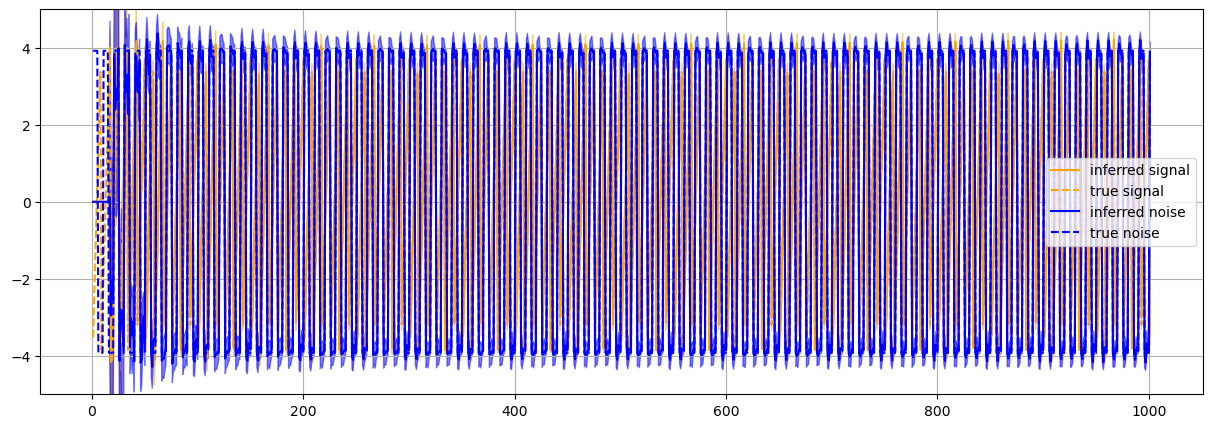

In [23]:
plt.figure(figsize=(15,5))
plt.fill_between(1:length(data_signal[1]), m_signal_filtering+sqrt.(V_signal_filtering), m_signal_filtering-sqrt.(V_signal_filtering), color="orange", alpha=0.5)
plt.plot(1:length(data_signal[1]), m_signal_filtering, color="orange", label="inferred signal")
plt.plot(1:length(data_signal[1]), data_mix_signal[1], color="orange", linestyle="--", label="true signal")
plt.fill_between(1:length(data_signal[1]), m_noise_filtering+sqrt.(V_noise_filtering), m_noise_filtering-sqrt.(V_noise_filtering), color="blue", alpha=0.5)
plt.plot(1:length(data_signal[1]), m_noise_filtering, color="blue", label="inferred noise")
plt.plot(1:length(data_signal[1]), data_mix_noise[1], color="blue", linestyle="--", label="true noise")
plt.grid()
plt.legend()
plt.ylim(-5,5)
# plt.xlim(0,100);

#### metrics

In [24]:
using ProgressMeter

In [25]:
MSE_filtering  = Vector{Float64}(undef, length(data_mix))
MSE_smoothing  = Vector{Float64}(undef, length(data_mix))
MAE_filtering  = Vector{Float64}(undef, length(data_mix))
MAE_smoothing  = Vector{Float64}(undef, length(data_mix))
logp_filtering = Vector{Float64}(undef, length(data_mix))
logp_smoothing = Vector{Float64}(undef, length(data_mix))

@showprogress for (ind, signal_mix) in enumerate(data_mix)

    # run EKF
    m_signal_filtering, V_signal_filtering, m_noise_filtering, V_noise_filtering = EKF_deployed(signal_mix, deployed_model_signal, deployed_model_noise, m_x_prior, V_x_prior, R, Q);

    # calculate metrics
    MSE_filtering[ind]  = sum(abs2.(m_signal_filtering[dim_in+1:end] .- data_mix_signal[ind][dim_in+1:end]))/(length(m_signal_filtering)-dim_in)
    MAE_filtering[ind]  = sum(abs.(m_signal_filtering[dim_in+1:end] .- data_mix_signal[ind][dim_in+1:end]))/(length(m_signal_filtering)-dim_in)
    logp_filtering[ind] = sum([logpdf(Normal(m_signal_filtering[k], sqrt(V_signal_filtering[k])), data_mix_signal[ind][k]) for k=1+dim_in:length(m_signal_filtering)])/(length(m_signal_filtering)-dim_in)

end

Progress: 100%|█████████████████████████████████████████| Time: 0:06:30


In [26]:
mean(MSE_filtering), mean(MAE_filtering), mean(logp_filtering)

(0.050750054046305865, 0.08836710130200712, -0.03920068407476962)

## Worst situation (filtering)

In [27]:
ind = argmax(MSE_filtering)

506

In [28]:
m_signal_filtering, V_signal_filtering, m_noise_filtering, V_noise_filtering = EKF(data_mix[ind], model_signal, model_noise, m_x_prior, V_x_prior, R, Q);

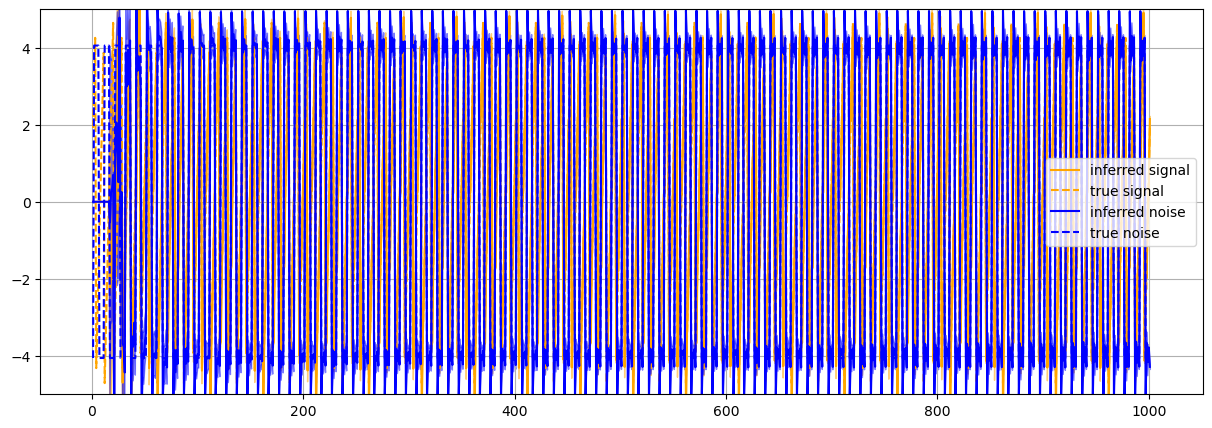

In [29]:
plt.figure(figsize=(15,5))
plt.fill_between(1:length(data_signal[ind]), m_signal_filtering+sqrt.(V_signal_filtering), m_signal_filtering-sqrt.(V_signal_filtering), color="orange", alpha=0.5)
plt.plot(1:length(data_signal[ind]), m_signal_filtering, color="orange", label="inferred signal")
plt.plot(1:length(data_signal[ind]), data_mix_signal[ind], color="orange", linestyle="--", label="true signal")
plt.fill_between(1:length(data_signal[ind]), m_noise_filtering+sqrt.(V_noise_filtering), m_noise_filtering-sqrt.(V_noise_filtering), color="blue", alpha=0.5)
plt.plot(1:length(data_signal[ind]), m_noise_filtering, color="blue", label="inferred noise")
plt.plot(1:length(data_signal[ind]), data_mix_noise[ind], color="blue", linestyle="--", label="true noise")
plt.grid()
plt.legend()
plt.ylim(-5,5)
# plt.xlim(0,100);